In [1]:
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.matlib
import numpy.random
from numpy import linalg as LA

### data preprocessing

In [2]:
animal=['Dove','Hen','Duck','Goose','Owl','Hawk','Eagle','Fox','Dog','Wolf','Cat','Tiger','Lion','Horse','Zebra','Cow']
a = 1.0
x_s = a * np.matlib.eye(16, k=0, dtype=float)
x_a = np.matrix('1 0 0 1 0 0 0 0 1 0 0 1 0;' \
                '1 0 0 1 0 0 0 0 1 0 0 0 0;' \
                '1 0 0 1 0 0 0 0 1 0 0 0 1;' \
                '1 0 0 1 0 0 0 0 1 0 0 1 1;' \
                '1 0 0 1 0 0 0 0 1 1 0 1 0;' \
                '1 0 0 1 0 0 0 0 1 1 0 1 0;' \
                '0 1 0 1 0 0 0 0 1 1 0 1 0;' \
                '0 1 0 0 1 1 0 0 0 1 0 0 0;' \
                '0 1 0 0 1 1 0 0 0 0 1 0 0;' \
                '0 1 0 0 1 1 0 1 0 1 1 0 0;' \
                '1 0 0 0 1 1 0 0 0 1 0 0 0;' \
                '0 0 1 0 1 1 0 0 0 1 1 0 0;' \
                '0 0 1 0 1 1 0 1 0 1 1 0 0;' \
                '0 0 1 0 1 1 1 1 0 0 1 0 0;' \
                '0 0 1 0 1 1 1 1 0 0 1 0 0;' \
                '0 0 1 0 1 1 1 0 0 0 0 0 0', dtype=float)

x_sa = np.hstack((x_s, x_a))
x_0a = np.hstack((np.zeros_like(x_s), x_a))
x_s0 = np.hstack((x_s, np.zeros_like(x_a)))
print(x_sa.shape)

(16, 29)


Normalize to unit length

In [3]:
x_sa = np.diagflat(1.0/LA.norm(x_sa, ord=2, axis=1)) * x_sa
x_0a = np.diagflat(1.0/LA.norm(x_0a, ord=2, axis=1)) * x_0a
x_s0 = np.diagflat(1.0/LA.norm(x_s0, ord=2, axis=1)) * x_s0
print("2-norm = ", LA.norm(x_sa, ord=2, axis=1))

('2-norm = ', array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.]))


#### training/testing data generator

In [4]:
class TrainGen(object):
    def __init__(self, x):
        self.x_ = x;
    def __iter__(self):
        idx = np.arange(self.x_.shape[0])
        while True:
            np.random.shuffle(idx)
            for i in idx:
                yield self.x_[i, :]
                
gen = iter(TrainGen(x_sa))

### SOM class

In [5]:
class SOFM2d(object):
    def __init__(self, map_x_dim, map_y_dim, feat_dim):
        self.map_x_dim = map_x_dim
        self.map_y_dim = map_y_dim
        self.feat_dim = feat_dim
        self.w = np.random.uniform(low=0.49, high=0.51, size=(map_x_dim* map_y_dim, feat_dim))
        self.sigma0 = 5
        self.eta0 = 0.1
        self.tau2 = 2000
        self.tau1 = self.tau2 / self.sigma0
        # compute d^2_{j,i}
        self.d2 = np.zeros((map_x_dim * map_y_dim, map_x_dim * map_y_dim), dtype=float)
        self.pos = [(x,y) for x in np.arange(map_x_dim) for y in np.arange(map_y_dim)]
        for xi,yi in self.pos:
            for xj, yj in self.pos:
                self.d2[xj*map_y_dim + yj, xi*map_y_dim + yi] = ((xi-xj) ** 2) + ((yi-yj) ** 2)

    def Matching(self, x):
        distance = LA.norm(x - self.w[:,:x.shape[1]], ord=2, axis=-1)
        winner_idx = np.argmin(distance)
        return winner_idx, distance[winner_idx]
    
    def Updating(self, x, winner_idx, n):
        # compute h_x(n)
        eta_n = self.eta0 * math.exp(-n / self.tau2)
        sigma_n = self.sigma0 * math.exp(-n / self.tau1)
        h_n = np.exp(-self.d2[:,winner_idx] / (2.0 * (sigma_n ** 2)))
        delta = eta_n * np.diagflat(h_n)* (x - self.w)
        self.w = self.w + delta
        return delta
    
    def Idx2Class(self, winner_idx):
        return np.argmax(self.w[winner_idx,:16])

#### training, 2000 iteration

In [6]:
model = SOFM2d(10, 10, 29)

for i in range(1, 2001):
    x = next(gen)
    winner_idx, dist = model.Matching(x)
    model.Updating(x, winner_idx, i*1.0)

#### plot

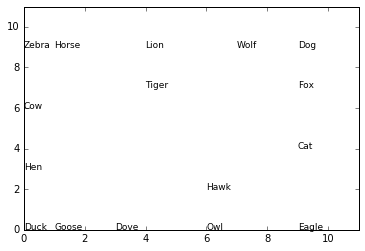

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
for idx in range(x_s.shape[0]):
    winner_idx,_ = model.Matching(x_s[idx,:])
    ax.text(winner_idx%10, winner_idx/10, animal[idx], fontsize=9)
    
ax.axis([0, 11, 0, 11])
plt.show()